In [1]:
%run notebook_setup

theano version: 1.0.4
pymc3 version: 3.7
exoplanet version: 0.3.3
scipy version: 1.5.2


In [2]:
run_trace = True # set to True to rerun all traces in full; otherwise loads saved
import pandas as pd
import corner
import astropy.units as u

### Load up HARPS data & fit

In [3]:
df = pd.read_csv("../../data/harps_rvs.csv")
for k in df.columns:
    new_k = k.strip("#").strip()
    if new_k != k:
        df[new_k] = df[k]
        del df[k]

In [4]:
BTJD_ref = 2457000
HARPS_upgrade = 2457218.5 # July 2015

# Remove one bisector outlier
df = df[df.bis < df.bis.max()]
        
df = df.sort_values("date")

pug = np.ascontiguousarray(df.bjd >= HARPS_upgrade, dtype=bool) # post-upgrade mask

t_h1 = np.ascontiguousarray(df.bjd[~pug], dtype=np.float64)
rv_h1 = np.ascontiguousarray(df.rv[~pug], dtype=np.float64)
rverr_h1 = np.ascontiguousarray(df.e_rv[~pug], dtype=np.float64)
#fwhm_h1 = np.ascontiguousarray((df.fwhm[~pug] - df.fwhm.mean()) / df.fwhm.std(), dtype=np.float64)
fwhm_h1 = np.ascontiguousarray(df.fwhm[~pug], dtype=np.float64)
fwhm_h1 -= np.median(fwhm_h1)
rv_h1 -= np.median(rv_h1)

t_h2 = np.ascontiguousarray(df.bjd[pug], dtype=np.float64)
rv_h2 = np.ascontiguousarray(df.rv[pug], dtype=np.float64)
rverr_h2 = np.ascontiguousarray(df.e_rv[pug], dtype=np.float64)
#fwhm_h2 = np.ascontiguousarray((df.fwhm[pug] - df.fwhm.mean()) / df.fwhm.std(), dtype=np.float64)
fwhm_h2 = np.ascontiguousarray(df.fwhm[pug], dtype=np.float64)
fwhm_h2 -= np.median(fwhm_h2)
rv_h2 -= np.median(rv_h2)

#### fixed zero eccentricity:

In [5]:
rv_trend_order = 1

t_dense = np.linspace(t_h1.min()-5, t_h2.max()+5, 1000)

with pm.Model() as model:
    # Keplerian parameters
    period = pm.Normal("period", mu=17.47128, sd=0.00005)
    t0 = pm.Normal("t0", mu=2458661.0628, sd=0.0007)   
    K = pm.Uniform("K", lower=0., upper=10., testval=5.)
    ecc = 0.
    omega = np.pi
    
    # RV offsets
    delta_rv = pm.Uniform("delta_rv", lower=-10., upper=10.) # mu_h2 - trend[1]
    if rv_trend_order == 1:
        trend = pm.Uniform("trend", lower=-10., upper=10.) # ideally this would be shape [1] but idk how to make that work so terrible hacks will follow
        #trend = pm.Normal("trend", mu=0, sd=3)
    else:
        trend = pm.Normal("trend", mu=0, sd=10.0**(1-np.arange(rv_trend_order))[::-1], shape=rv_trend_order)
    
    # RV jitter
    logs_h1 = pm.Uniform("logs_h1", lower=0., upper=10.)
    logs_h2 = pm.Uniform("logs_h2", lower=0., upper=10.)
    
    # FWHM trend
    delta_fwhm = pm.Normal("delta_fwhm", mu=1., sd=5) # weak prior from eyeballing
    trend_fwhm = pm.Normal("trend_fwhm", mu=0, sd=10.)
            
    # Orbit model
    orbit_rvs = xo.orbits.KeplerianOrbit(
        period=period,
        ecc=ecc, omega=omega)
    
    # Save some helpful things for later
    semimajor = orbit_rvs.a
    pm.Deterministic('a', semimajor)
    
    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad_h1 = orbit_rvs.get_radial_velocity(t_h1, K=K)
    vrad_h2 = orbit_rvs.get_radial_velocity(t_h2, K=K)
    vrad = orbit_rvs.get_radial_velocity(np.append(t_h1, t_h2), K=K)
    pm.Deterministic("vrad", vrad)
    
    # RV noise model for h1
    bkg_terms_h1 = fwhm_h1 * trend_fwhm
    if rv_trend_order == 1:
        bkg_terms_h1 += trend
    else:
        A_trend_h1 = np.vander(t_h1, rv_trend_order)
        bkg_terms_h1 += tt.dot(A_trend_h1, trend)
    bkg_h1 = pm.Deterministic("bkg_h1", bkg_terms_h1)
        
    # RV noise model for h2
    bkg_terms_h2 = (fwhm_h2 - delta_fwhm) * trend_fwhm
    if rv_trend_order == 1:
        bkg_terms_h2 += trend + delta_rv
    else:
        A_trend_h2 = np.vander(t_h2, rv_trend_order)
        bkg_terms_h2 += tt.dot(A_trend_h2, trend) + delta_rv
    bkg_h2 = pm.Deterministic("bkg_h2", bkg_terms_h2)

    # The likelihood for the RVs
    rv_model_h1 = pm.Deterministic("rv_model_h1", vrad_h1 + bkg_h1)  
    rv_model_h2 = pm.Deterministic("rv_model_h2", vrad_h2 + bkg_h2)        
    err_h1 = tt.sqrt(rverr_h1**2 + tt.exp(2*logs_h1))
    err_h2 = tt.sqrt(rverr_h2**2 + tt.exp(2*logs_h2))
    pm.Normal("obs_h1", mu=rv_model_h1, sd=err_h1, observed=rv_h1)
    pm.Normal("obs_h2", mu=rv_model_h2, sd=err_h2, observed=rv_h2)
        
    vrad_pred = orbit_rvs.get_radial_velocity(t_dense, K=K)
    pm.Deterministic("vrad_pred", vrad_pred)
    if rv_trend_order == 1:
        bkg_pred = pm.Deterministic("bkg_pred", np.ones_like(t_dense) + trend)
    else:
        A_pred = np.vander(t_dense, rv_trend_order)        
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    pm.Deterministic("rv_model_pred", vrad_pred + bkg_pred)

    # Fit for the maximum a posteriori parameters
    start = model.test_point
    map_soln = start
    map_soln = xo.optimize(start=map_soln, vars=[logs_h1, logs_h2, trend, delta_rv])
    map_soln = xo.optimize(start=map_soln, vars=[trend_fwhm, delta_fwhm])
    map_soln = xo.optimize(start=map_soln, vars=[period, t0])
    map_soln = xo.optimize(start=map_soln, vars=[K])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [delta_rv, trend, logs_h2, logs_h1]


message: Optimization terminated successfully.
logp: -322.9305935419533 -> -168.05883674610595
optimizing logp for variables: [delta_fwhm, trend_fwhm]


message: Optimization terminated successfully.
logp: -168.05883674610595 -> -168.05613376806582
optimizing logp for variables: [t0, period]


message: Desired error not necessarily achieved due to precision loss.
logp: -168.05613376806582 -> -167.89053633086797
optimizing logp for variables: [K]


message: Optimization terminated successfully.
logp: -167.89053633086797 -> -167.08122528344686
optimizing logp for variables: [trend_fwhm, delta_fwhm, logs_h2, logs_h1, trend, delta_rv, K, t0, period]


message: Desired error not necessarily achieved due to precision loss.
logp: -167.08122528344686 -> -166.65621469617065


In [6]:
if run_trace:
    with model:
        trace = pm.sample(tune=1000, draws=1000, start=map_soln, chains=2,
                      step=xo.get_dense_nuts_step(target_accept=0.9))
    pm.save_trace(trace,directory='trace_fwhm_noecc_o{0}'.format(rv_trend_order), overwrite=True)   
else:
    with model:
        trace = pm.load_trace('trace_fwhm_noecc_o{0}'.format(rv_trend_order))

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [trend_fwhm, delta_fwhm, logs_h2, logs_h1, trend, delta_rv, K, t0, period]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:26<00:00, 153.46draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [7]:
for varname in ["period", "t0", "K", "delta_rv", "delta_fwhm", 
                "trend", "trend_fwhm", "logs_h1", "logs_h2"]:
    print("{0}: median {1} +{2} -{3}; MAP {4}".format(varname, np.median(trace[varname], axis=0), 
                                                      np.percentile(trace[varname], [84], axis=0) - np.median(trace[varname], axis=0), 
                                                      np.median(trace[varname], axis=0) - np.percentile(trace[varname], [16], axis=0), 
                                                      map_soln[varname]))

period: median 17.47127546652266 +[8.36193871e-06] -[1.13870421e-05]; MAP 17.471276434086885
t0: median 2458661.062755096 +[0.00073557] -[0.00067011]; MAP 2458661.0628
K: median 2.690586573201694 +[1.23700392] -[1.19519103]; MAP 3.297761945454517
delta_rv: median -0.10567183219724274 +[6.18571655] -[5.82268066]; MAP 0.2497624273664112
delta_fwhm: median 0.22234076521562668 +[2.3632671] -[2.11576809]; MAP 0.8097108983656658
trend: median 0.9907695094302333 +[0.90212616] -[0.86949879]; MAP 1.0560973024525726
trend_fwhm: median 0.5566723933187546 +[5.52605116] -[4.23228235]; MAP 1.5227814127054768
logs_h1: median 1.6399828931963663 +[0.12991485] -[0.1359981]; MAP 1.611121702986116
logs_h2: median 1.7348195990488318 +[0.18284679] -[0.17168877]; MAP 1.6640392463375746


In [8]:
print('period: {0:.7f} + {1:.7f} - {2:.7f}'.format(np.median(trace['period']), 
                                                    np.percentile(trace['period'], 84) - np.median(trace['period']), 
                                                    np.median(trace['period']) - np.percentile(trace['period'], 16)))
print('t0: {0:.5f} + {1:.5f} - {2:.5f}'.format(np.median(trace['t0']), 
                                                    np.percentile(trace['t0'], 84) - np.median(trace['t0']), 
                                                    np.median(trace['t0']) - np.percentile(trace['t0'], 16)))
print('K: {0:.2f} + {1:.2f} - {2:.2f}'.format(np.median(trace['K']), 
                                                    np.percentile(trace['K'], 84) - np.median(trace['K']), 
                                                    np.median(trace['K']) - np.percentile(trace['K'], 16)))
if rv_trend_order>1:
    print('mu_h1: {0:.2f} + {1:.2f} - {2:.2f}'.format(np.median(trace['trend'], axis=0)[-1], 
                                                    np.percentile(trace['trend'], 84, axis=0)[-1] - np.median(trace['trend'], axis=0)[-1], 
                                                    np.median(trace['trend'], axis=0)[-1] - np.percentile(trace['trend'], 16, axis=0)[-1]))
    print('mu_h2: {0:.2f} + {1:.2f} - {2:.2f}'.format(np.median(trace['trend'], axis=0)[-1] + np.median(trace['delta_rv']), 
                                                    np.percentile(trace['delta_rv'], 84) - np.median(trace['delta_rv']), 
                                                    np.median(trace['delta_rv']) - np.percentile(trace['delta_rv'], 16)))
else:
    print('mu_h1: {0:.2f} + {1:.2f} - {2:.2f}'.format(np.median(trace['trend']), 
                                                    np.percentile(trace['trend'], 84) - np.median(trace['trend']), 
                                                    np.median(trace['trend']) - np.percentile(trace['trend'], 16)))
    print('mu_h2: {0:.2f} + {1:.2f} - {2:.2f}'.format(np.median(trace['trend']) + np.median(trace['delta_rv']), 
                                                    np.percentile(trace['delta_rv'], 84) - np.median(trace['delta_rv']), 
                                                    np.median(trace['delta_rv']) - np.percentile(trace['delta_rv'], 16)))
print('s_h1: {0:.2f} + {1:.2f} - {2:.2f}'.format(np.exp(np.median(trace['logs_h1'])), 
                                                    np.exp(np.percentile(trace['logs_h1'], 84)) - np.exp(np.median(trace['logs_h1'])), 
                                                    np.exp(np.median(trace['logs_h1'])) - np.exp(np.percentile(trace['logs_h1'], 16))))
print('s_h2: {0:.2f} + {1:.2f} - {2:.2f}'.format(np.exp(np.median(trace['logs_h2'])), 
                                                    np.exp(np.percentile(trace['logs_h2'], 84)) - np.exp(np.median(trace['logs_h2'])), 
                                                    np.exp(np.median(trace['logs_h2'])) - np.exp(np.percentile(trace['logs_h2'], 16))))

print('omega: {0:.1f} + {1:.1f} - {2:.1f}'.format(np.median(trace['trend_fwhm']), 
                                                    np.percentile(trace['trend_fwhm'], 84) - np.median(trace['trend_fwhm']), 
                                                    np.median(trace['trend_fwhm']) - np.percentile(trace['trend_fwhm'], 16)))

period: 17.4712755 + 0.0000084 - 0.0000114
t0: 2458661.06276 + 0.00074 - 0.00067
K: 2.69 + 1.24 - 1.20
mu_h1: 0.99 + 0.90 - 0.87
mu_h2: 0.89 + 6.19 - 5.82
s_h1: 5.16 + 0.72 - 0.66
s_h2: 5.67 + 1.14 - 0.89
omega: 0.6 + 5.5 - 4.2


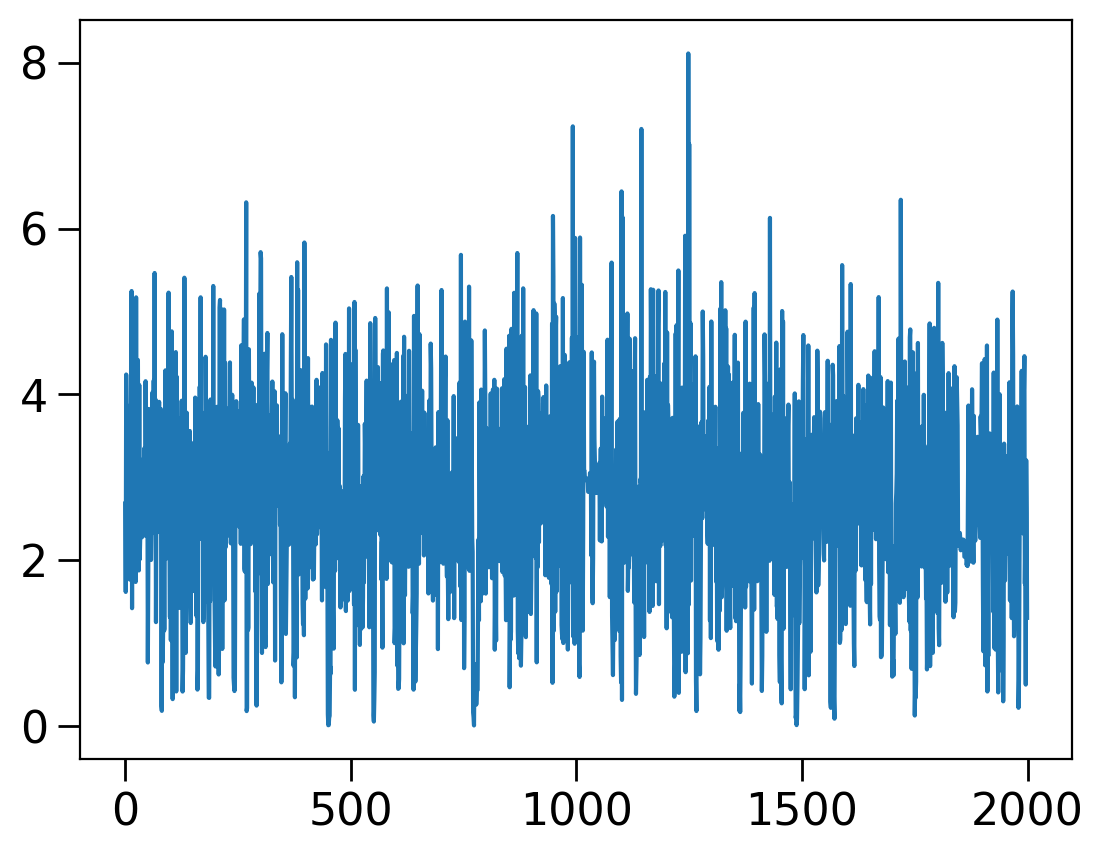

In [9]:
plt.plot(trace['K']);

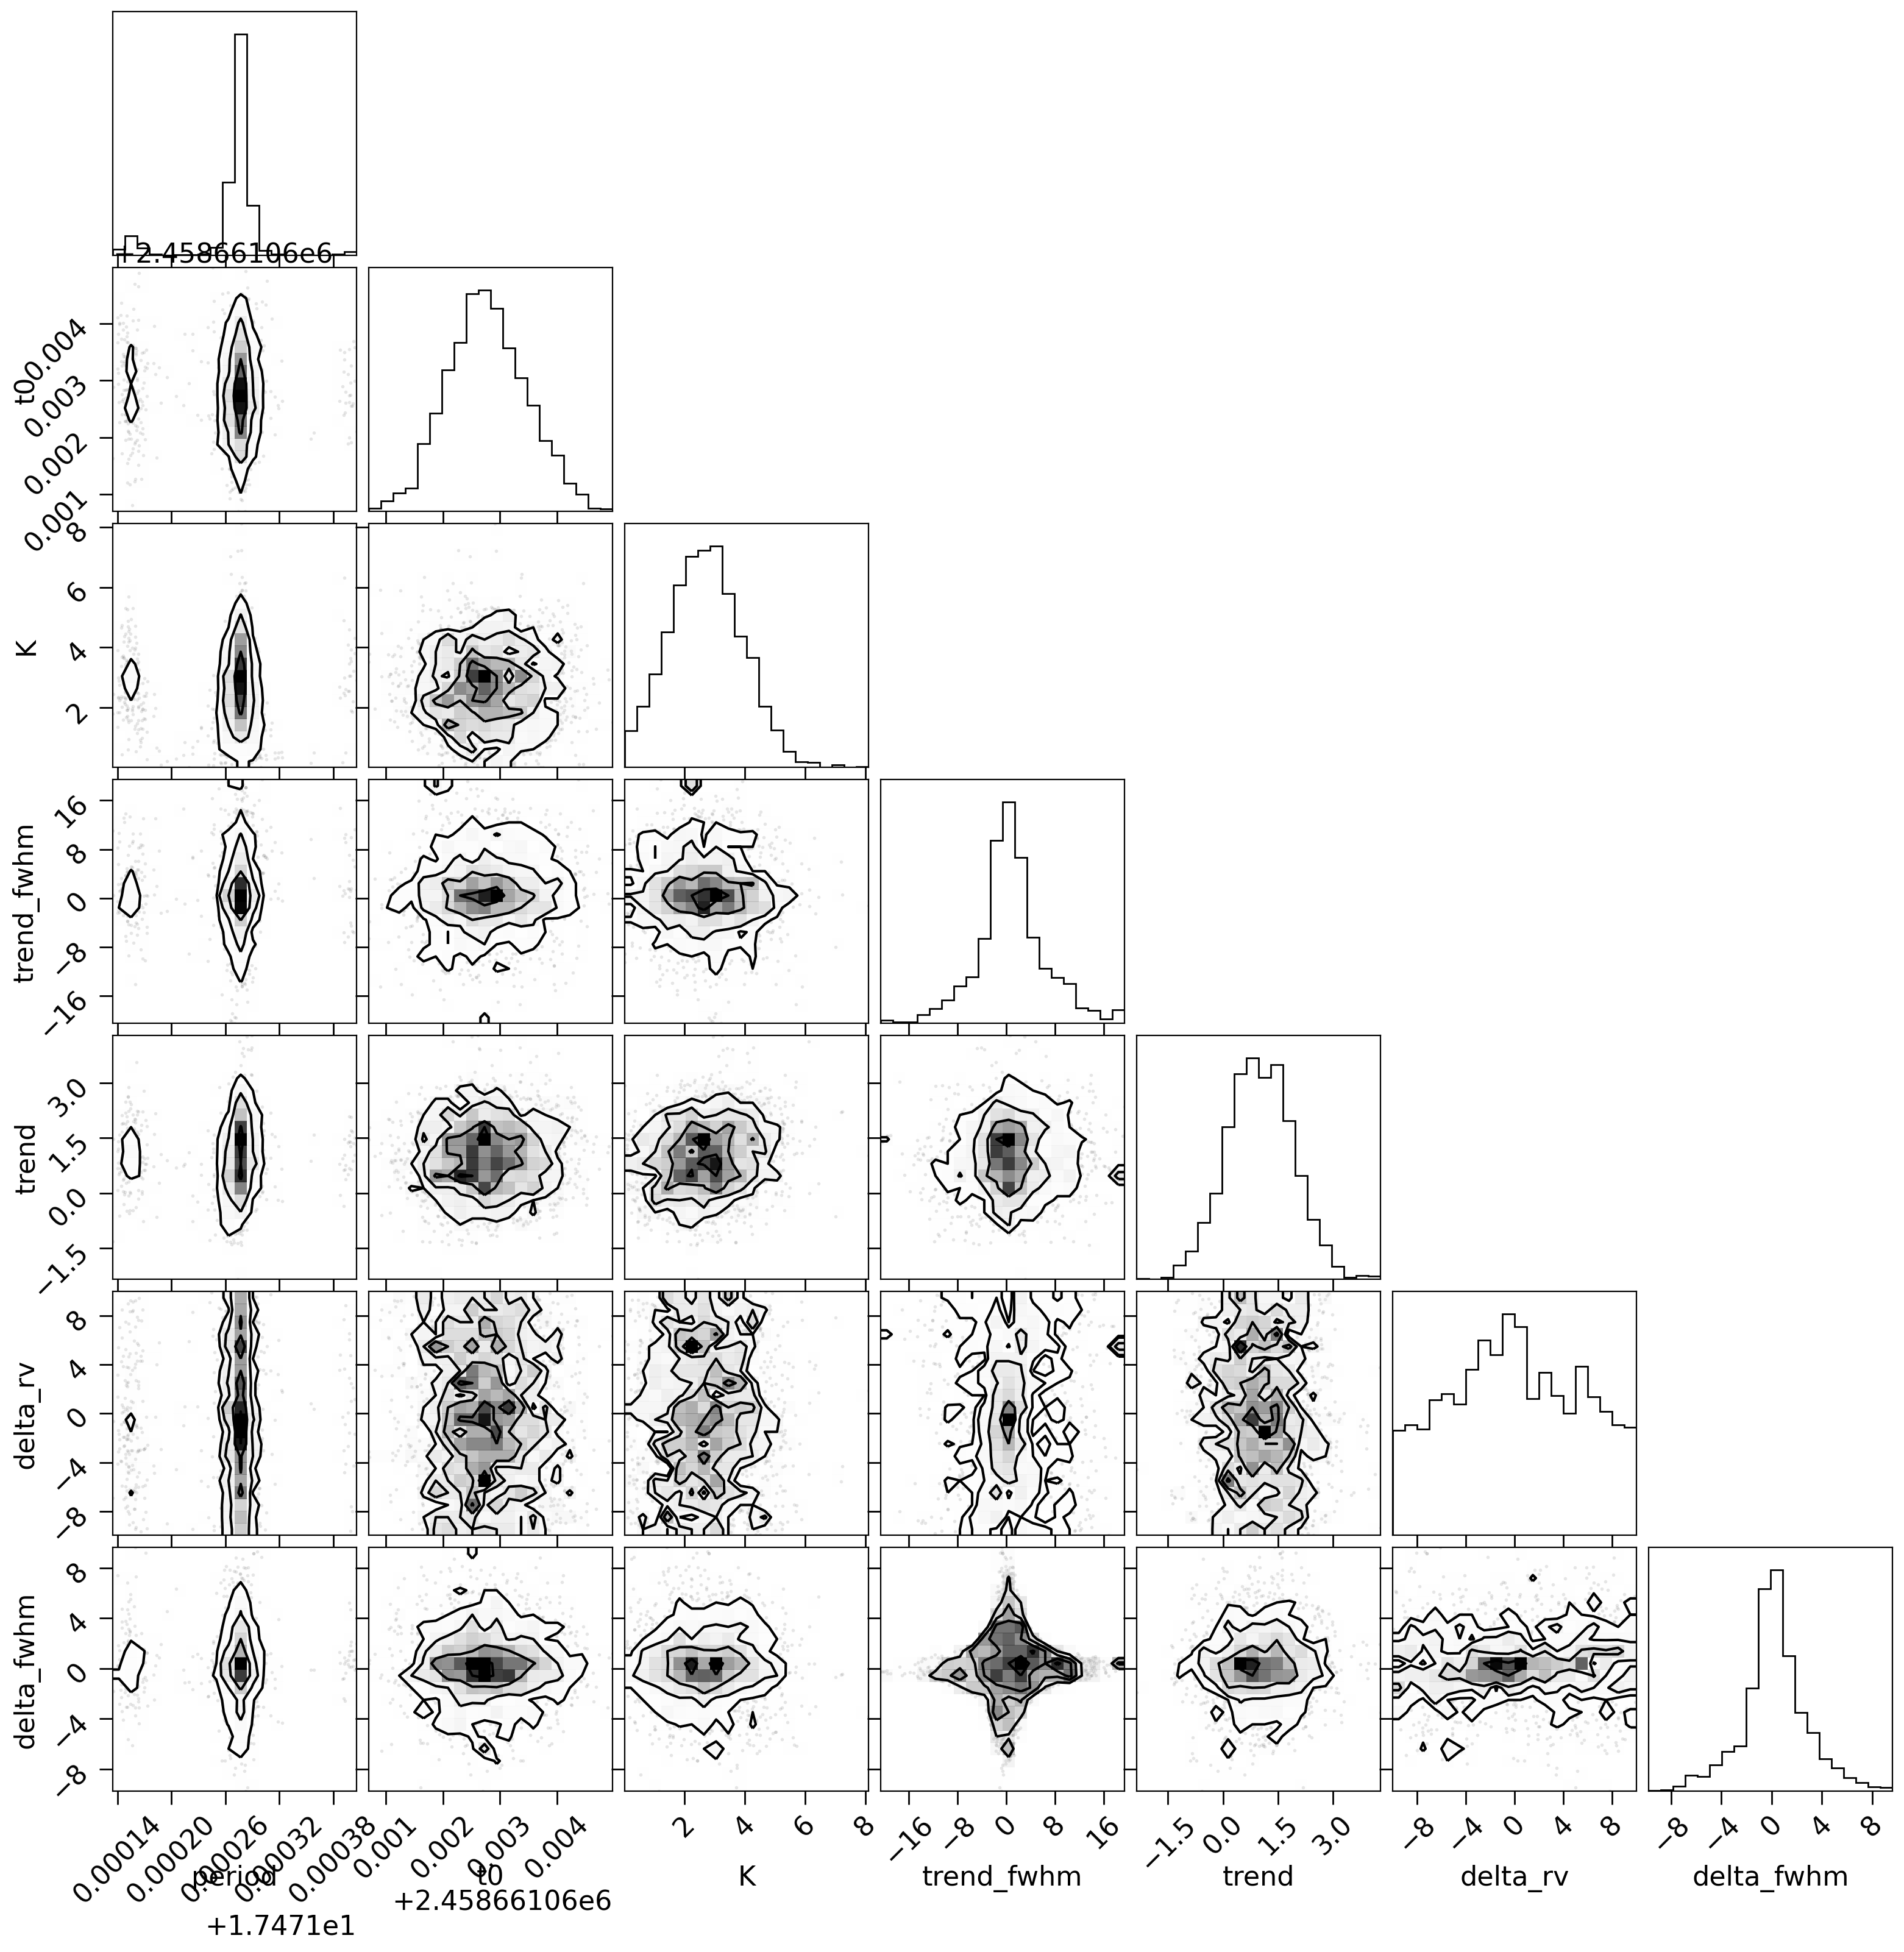

In [10]:
varnames = ["period", "t0", "K", "trend_fwhm", "trend", "delta_rv", "delta_fwhm"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

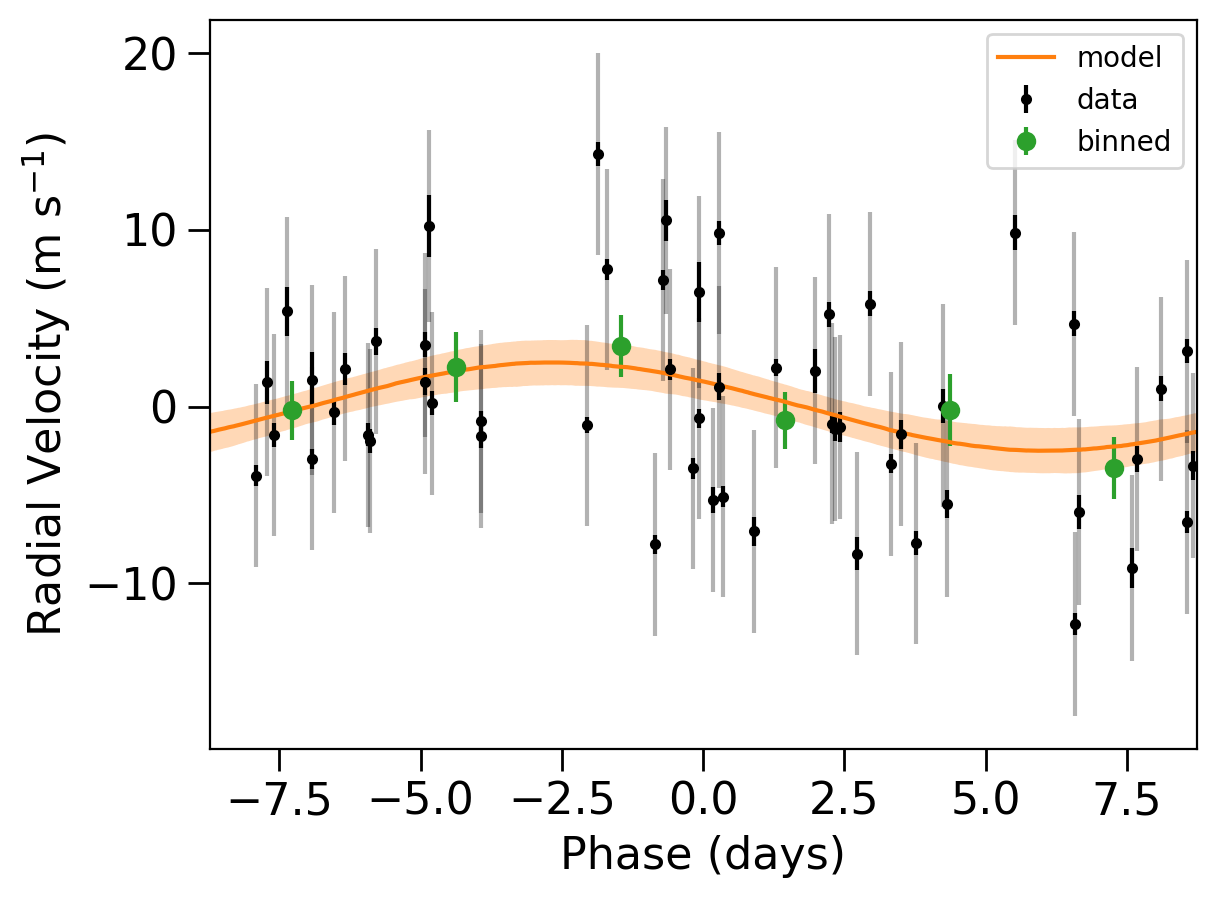

In [11]:
# Get the posterior median orbital parameters
if True:
    p = np.median(trace["period"])
    t0 = np.median(trace["t0"])
    bkg_h1 = np.median(trace["bkg_h1"], axis=0)
    bkg_h2 = np.median(trace["bkg_h2"], axis=0)
    rverr_h1_corrected = np.sqrt(rverr_h1**2+np.exp(2*np.median(trace["logs_h1"])))
    rverr_h2_corrected = np.sqrt(rverr_h2**2+np.exp(2*np.median(trace["logs_h2"])))

# or get the MAP parameters instead
if False:
    p = map_soln["period"]
    t0 = map_soln["t0"]
    bkg_h1 = map_soln["bkg_h1"]
    bkg_h2 = map_soln["bkg_h2"]
    rverr_h1_corrected = np.sqrt(rverr_h1**2+np.exp(2*map_soln["logs_h1"]))
    rverr_h2_corrected = np.sqrt(rverr_h2**2+np.exp(2*map_soln["logs_h2"]))

# Plot the folded data
t_h1_fold = (t_h1 - t0 + 0.5*p) % p - 0.5*p
t_h2_fold = (t_h2 - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(t_h1_fold, rv_h1 - bkg_h1, yerr=rverr_h1_corrected, fmt=",k", alpha=0.3)
plt.errorbar(t_h2_fold, rv_h2 - bkg_h2, yerr=rverr_h2_corrected, fmt=",k", alpha=0.3)
plt.errorbar(t_h1_fold, rv_h1 - bkg_h1, yerr=rverr_h1, fmt=".k", label="data")
plt.errorbar(t_h2_fold, rv_h2 - bkg_h2, yerr=rverr_h2, fmt=".k")


bins = np.linspace(-0.5 * p, 0.5*p, 7)
t_all_fold = np.concatenate([t_h1_fold, t_h2_fold])
weights_all = np.concatenate([(rv_h1 - bkg_h1) / rverr_h1_corrected**2, 
                         (rv_h2 - bkg_h2) / rverr_h2_corrected**2])
weights2_all = np.concatenate([1 / rverr_h1_corrected**2, 1 / rverr_h2_corrected**2])
num, _ = np.histogram(t_all_fold, bins, weights=weights_all)
denom, _ = np.histogram(t_all_fold, bins, weights=weights2_all)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

# Compute the posterior prediction for the folded RV model for this
# planet
t_fold = (t_dense - t0 + 0.5*p) % p - 0.5*p
inds = np.argsort(t_fold)
pred = np.percentile(trace["vrad_pred"][:, inds], [16, 50, 84], axis=0)
plt.plot(t_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
art.set_edgecolor("none")


plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("Phase (days)")
plt.ylabel("Radial Velocity (m s$^{-1}$)")
plt.tight_layout()
plt.savefig(plot_dir+'rvphased_fwhm_noecc_o{0}.pdf'.format(rv_trend_order));

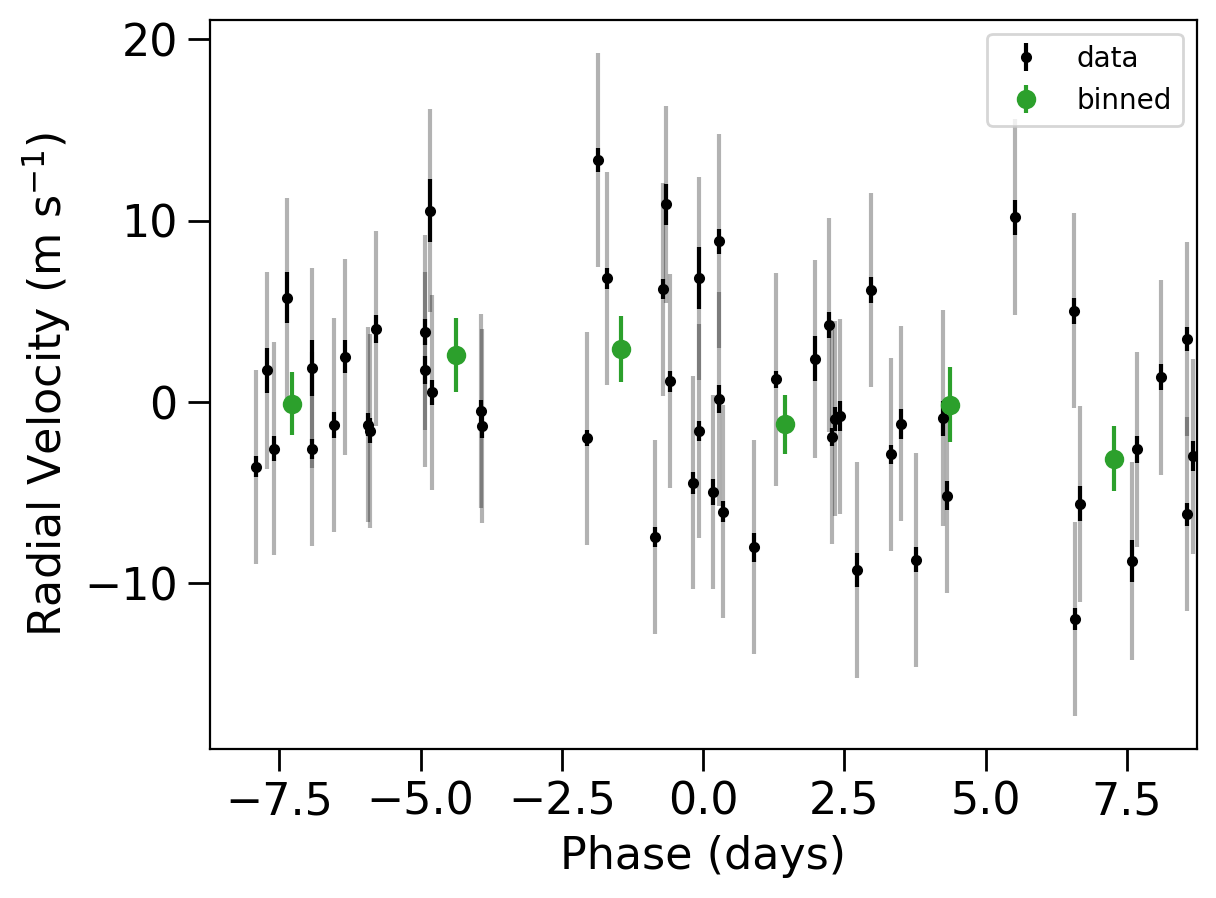

In [12]:
# from Tianjun:
p = 17.47129
t0 = 2458661.06279
bkg_h1 = np.zeros_like(t_h1) + 0.64
bkg_h2 = np.zeros_like(t_h2) + 1.28
rverr_h1_corrected = np.sqrt(rverr_h1**2+5.32**2)
rverr_h2_corrected = np.sqrt(rverr_h2**2+5.86**2)

# Plot the folded data
t_h1_fold = (t_h1 - t0 + 0.5*p) % p - 0.5*p
t_h2_fold = (t_h2 - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(t_h1_fold, rv_h1 - bkg_h1, yerr=rverr_h1_corrected, fmt=",k", alpha=0.3)
plt.errorbar(t_h2_fold, rv_h2 - bkg_h2, yerr=rverr_h2_corrected, fmt=",k", alpha=0.3)
plt.errorbar(t_h1_fold, rv_h1 - bkg_h1, yerr=rverr_h1, fmt=".k", label="data")
plt.errorbar(t_h2_fold, rv_h2 - bkg_h2, yerr=rverr_h2, fmt=".k")


bins = np.linspace(-0.5 * p, 0.5*p, 7)
t_all_fold = np.concatenate([t_h1_fold, t_h2_fold])
weights_all = np.concatenate([(rv_h1 - bkg_h1) / rverr_h1_corrected**2, 
                         (rv_h2 - bkg_h2) / rverr_h2_corrected**2])
weights2_all = np.concatenate([1 / rverr_h1_corrected**2, 1 / rverr_h2_corrected**2])
num, _ = np.histogram(t_all_fold, bins, weights=weights_all)
denom, _ = np.histogram(t_all_fold, bins, weights=weights2_all)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")


plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("Phase (days)")
plt.ylabel("Radial Velocity (m s$^{-1}$)")
plt.tight_layout()
#plt.savefig(plot_dir+'rvphased_fwhm_noecc.pdf');

#### variable eccentricity:

In [13]:
with pm.Model() as model:
    # Keplerian parameters
    period = pm.Normal("period", mu=17.47128, sd=0.00005)
    t0 = pm.Normal("t0", mu=2458661.0628, sd=0.0007)   
    K = pm.Uniform("K", lower=0., upper=10., testval=5.)
    ecc = xo.distributions.eccentricity.kipping13("ecc", testval=0.01)
    omega = xo.distributions.Angle("omega", testval=np.pi)
    
    # RV offsets
    delta_rv = pm.Uniform("delta_rv", lower=-10., upper=10.) # mu_h2 - trend[1]
    if rv_trend_order == 1:
        trend = pm.Uniform("trend", lower=-10., upper=10.) # ideally this would be shape [1] but idk how to make that work so terrible hacks will follow
        #trend = pm.Normal("trend", mu=0, sd=3)
    else:
        trend = pm.Normal("trend", mu=0, sd=10.0**(1-np.arange(rv_trend_order))[::-1], shape=rv_trend_order)
    
    # RV jitter
    logs_h1 = pm.Uniform("logs_h1", lower=0., upper=10.)
    logs_h2 = pm.Uniform("logs_h2", lower=0., upper=10.)
    
    # FWHM trend
    delta_fwhm = pm.Normal("delta_fwhm", mu=1., sd=5) # weak prior from eyeballing
    trend_fwhm = pm.Normal("trend_fwhm", mu=0, sd=10.)
            
    # Orbit model
    orbit_rvs = xo.orbits.KeplerianOrbit(
        period=period,
        ecc=ecc, omega=omega)
    
    # Save some helpful things for later
    semimajor = orbit_rvs.a
    pm.Deterministic('a', semimajor)
    
    # Set up the RV model and save it as a deterministic
    # for plotting purposes later
    vrad_h1 = orbit_rvs.get_radial_velocity(t_h1, K=K)
    vrad_h2 = orbit_rvs.get_radial_velocity(t_h2, K=K)
    vrad = orbit_rvs.get_radial_velocity(np.append(t_h1, t_h2), K=K)
    pm.Deterministic("vrad", vrad)
    
    # RV noise model for h1
    bkg_terms_h1 = fwhm_h1 * trend_fwhm
    if rv_trend_order == 1:
        bkg_terms_h1 += trend
    else:
        A_trend_h1 = np.vander(t_h1, rv_trend_order)
        bkg_terms_h1 += tt.dot(A_trend_h1, trend)
    bkg_h1 = pm.Deterministic("bkg_h1", bkg_terms_h1)
        
    # RV noise model for h2
    bkg_terms_h2 = (fwhm_h2 - delta_fwhm) * trend_fwhm
    if rv_trend_order == 1:
        bkg_terms_h2 += trend + delta_rv
    else:
        A_trend_h2 = np.vander(t_h2, rv_trend_order)
        bkg_terms_h2 += tt.dot(A_trend_h2, trend) + delta_rv
    bkg_h2 = pm.Deterministic("bkg_h2", bkg_terms_h2)

    # The likelihood for the RVs
    rv_model_h1 = pm.Deterministic("rv_model_h1", vrad_h1 + bkg_h1)  
    rv_model_h2 = pm.Deterministic("rv_model_h2", vrad_h2 + bkg_h2)        
    err_h1 = tt.sqrt(rverr_h1**2 + tt.exp(2*logs_h1))
    err_h2 = tt.sqrt(rverr_h2**2 + tt.exp(2*logs_h2))
    pm.Normal("obs_h1", mu=rv_model_h1, sd=err_h1, observed=rv_h1)
    pm.Normal("obs_h2", mu=rv_model_h2, sd=err_h2, observed=rv_h2)
        
    vrad_pred = orbit_rvs.get_radial_velocity(t_dense, K=K)
    pm.Deterministic("vrad_pred", vrad_pred)
    if rv_trend_order == 1:
        bkg_pred = pm.Deterministic("bkg_pred", np.ones_like(t_dense) + trend)
    else:
        A_pred = np.vander(t_dense, rv_trend_order)        
        bkg_pred = pm.Deterministic("bkg_pred", tt.dot(A_pred, trend))
    pm.Deterministic("rv_model_pred", vrad_pred + bkg_pred)

    # Fit for the maximum a posteriori parameters
    start = model.test_point
    map_soln = start
    map_soln = xo.optimize(start=map_soln, vars=[logs_h1, logs_h2, trend, delta_rv])
    map_soln = xo.optimize(start=map_soln, vars=[trend_fwhm, delta_fwhm])
    map_soln = xo.optimize(start=map_soln, vars=[period, t0])
    map_soln = xo.optimize(start=map_soln, vars=[K])
    map_soln = xo.optimize(start=map_soln, vars=[ecc, omega])
    map_soln = xo.optimize(start=map_soln)

optimizing logp for variables: [delta_rv, trend, logs_h2, logs_h1]


message: Optimization terminated successfully.
logp: -324.36714512952835 -> -169.45610559726094
optimizing logp for variables: [delta_fwhm, trend_fwhm]


message: Optimization terminated successfully.
logp: -169.45610559726094 -> -169.45354123122942
optimizing logp for variables: [t0, period]


message: Desired error not necessarily achieved due to precision loss.
logp: -169.45354123122942 -> -169.3292019832422
optimizing logp for variables: [K]


message: Optimization terminated successfully.
logp: -169.3292019832422 -> -168.4988245687861
optimizing logp for variables: [omega, ecc]


message: Optimization terminated successfully.
logp: -168.4988245687861 -> -145.69436422295527
optimizing logp for variables: [trend_fwhm, delta_fwhm, logs_h2, logs_h1, trend, delta_rv, omega, ecc, ecc_beta, ecc_alpha, K, t0, period]


message: Desired error not necessarily achieved due to precision loss.
logp: -145.69436422295527 -> -144.57159593543804


In [14]:
if run_trace:
    with model:
        trace = pm.sample(tune=1000, draws=1000, start=map_soln, chains=2,
                      step=xo.get_dense_nuts_step(target_accept=0.9))
    pm.save_trace(trace,directory='trace_fwhm_o{0}'.format(rv_trend_order), overwrite=True)   
else:
    with model:
        trace = pm.load_trace('trace_fwhm_o{0}'.format(rv_trend_order))

Multiprocess sampling (2 chains in 4 jobs)
NUTS: [trend_fwhm, delta_fwhm, logs_h2, logs_h1, trend, delta_rv, omega, ecc, ecc_beta, ecc_alpha, K, t0, period]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:44<00:00, 90.62draws/s] 
There were 51 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8368946855712108, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
for varname in ["period", "t0", "K", "delta_rv", "delta_fwhm", 
                "trend", "trend_fwhm", "logs_h1", "logs_h2",
                "ecc", "omega"]:
    print("{0}: median {1} +{2} -{3}; MAP {4}".format(varname, np.median(trace[varname], axis=0), 
                                                      np.percentile(trace[varname], [84], axis=0) - np.median(trace[varname], axis=0), 
                                                      np.median(trace[varname], axis=0) - np.percentile(trace[varname], [16], axis=0), 
                                                      map_soln[varname]))

period: median 17.471276821136165 +[1.55606376e-05] -[1.3400145e-05]; MAP 17.47126427893048
t0: median 2458661.0627865675 +[0.00073735] -[0.00066536]; MAP 2458661.0628
K: median 2.6491069376944996 +[1.3066827] -[1.26185196]; MAP 3.8686937785358424
delta_rv: median -0.2161102278309741 +[6.50236196] -[6.4311556]; MAP 0.2726055759760211
delta_fwhm: median 0.2952182988652695 +[2.93059413] -[2.21822661]; MAP 0.771423922255809
trend: median 0.9686833331405396 +[0.89044296] -[0.91219815]; MAP 1.3053415993575896
trend_fwhm: median 0.46433688642613025 +[4.71273564] -[4.38742875]; MAP 1.6757272673944479
logs_h1: median 1.6534864464585006 +[0.12482778] -[0.13449481]; MAP 1.6276674396158144
logs_h2: median 1.7570958265037784 +[0.17265437] -[0.17885846]; MAP 1.6140282425489936
ecc: median 0.19664037165765366 +[0.2672425] -[0.13513913]; MAP 0.34445936206490285
omega: median -0.17069232770542264 +[2.29954103] -[2.20565163]; MAP 0.28920454732902595


In [16]:
print('period: {0:.7f} + {1:.7f} - {2:.7f}'.format(np.median(trace['period']), 
                                                    np.percentile(trace['period'], 84) - np.median(trace['period']), 
                                                    np.median(trace['period']) - np.percentile(trace['period'], 16)))
print('t0: {0:.5f} + {1:.5f} - {2:.5f}'.format(np.median(trace['t0']), 
                                                    np.percentile(trace['t0'], 84) - np.median(trace['t0']), 
                                                    np.median(trace['t0']) - np.percentile(trace['t0'], 16)))
print('K: {0:.2f} + {1:.2f} - {2:.2f}'.format(np.median(trace['K']), 
                                                    np.percentile(trace['K'], 84) - np.median(trace['K']), 
                                                    np.median(trace['K']) - np.percentile(trace['K'], 16)))
if rv_trend_order>1:
    print('mu_h1: {0:.2f} + {1:.2f} - {2:.2f}'.format(np.median(trace['trend'], axis=0)[-1], 
                                                    np.percentile(trace['trend'], 84, axis=0)[-1] - np.median(trace['trend'], axis=0)[-1], 
                                                    np.median(trace['trend'], axis=0)[-1] - np.percentile(trace['trend'], 16, axis=0)[-1]))
    print('mu_h2: {0:.2f} + {1:.2f} - {2:.2f}'.format(np.median(trace['trend'], axis=0)[-1] + np.median(trace['delta_rv']), 
                                                    np.percentile(trace['delta_rv'], 84) - np.median(trace['delta_rv']), 
                                                    np.median(trace['delta_rv']) - np.percentile(trace['delta_rv'], 16)))
else:
    print('mu_h1: {0:.2f} + {1:.2f} - {2:.2f}'.format(np.median(trace['trend']), 
                                                    np.percentile(trace['trend'], 84) - np.median(trace['trend']), 
                                                    np.median(trace['trend']) - np.percentile(trace['trend'], 16)))
    print('mu_h2: {0:.2f} + {1:.2f} - {2:.2f}'.format(np.median(trace['trend']) + np.median(trace['delta_rv']), 
                                                    np.percentile(trace['delta_rv'], 84) - np.median(trace['delta_rv']), 
                                                    np.median(trace['delta_rv']) - np.percentile(trace['delta_rv'], 16)))
print('s_h1: {0:.2f} + {1:.2f} - {2:.2f}'.format(np.exp(np.median(trace['logs_h1'])), 
                                                    np.exp(np.percentile(trace['logs_h1'], 84)) - np.exp(np.median(trace['logs_h1'])), 
                                                    np.exp(np.median(trace['logs_h1'])) - np.exp(np.percentile(trace['logs_h1'], 16))))
print('s_h2: {0:.2f} + {1:.2f} - {2:.2f}'.format(np.exp(np.median(trace['logs_h2'])), 
                                                    np.exp(np.percentile(trace['logs_h2'], 84)) - np.exp(np.median(trace['logs_h2'])), 
                                                    np.exp(np.median(trace['logs_h2'])) - np.exp(np.percentile(trace['logs_h2'], 16))))
print('omega: {0:.1f} + {1:.1f} - {2:.1f}'.format(np.median(trace['trend_fwhm']), 
                                                    np.percentile(trace['trend_fwhm'], 84) - np.median(trace['trend_fwhm']), 
                                                    np.median(trace['trend_fwhm']) - np.percentile(trace['trend_fwhm'], 16)))

period: 17.4712768 + 0.0000156 - 0.0000134
t0: 2458661.06279 + 0.00074 - 0.00067
K: 2.65 + 1.31 - 1.26
mu_h1: 0.97 + 0.89 - 0.91
mu_h2: 0.75 + 6.50 - 6.43
s_h1: 5.23 + 0.69 - 0.66
s_h2: 5.80 + 1.09 - 0.95
omega: 0.5 + 4.7 - 4.4


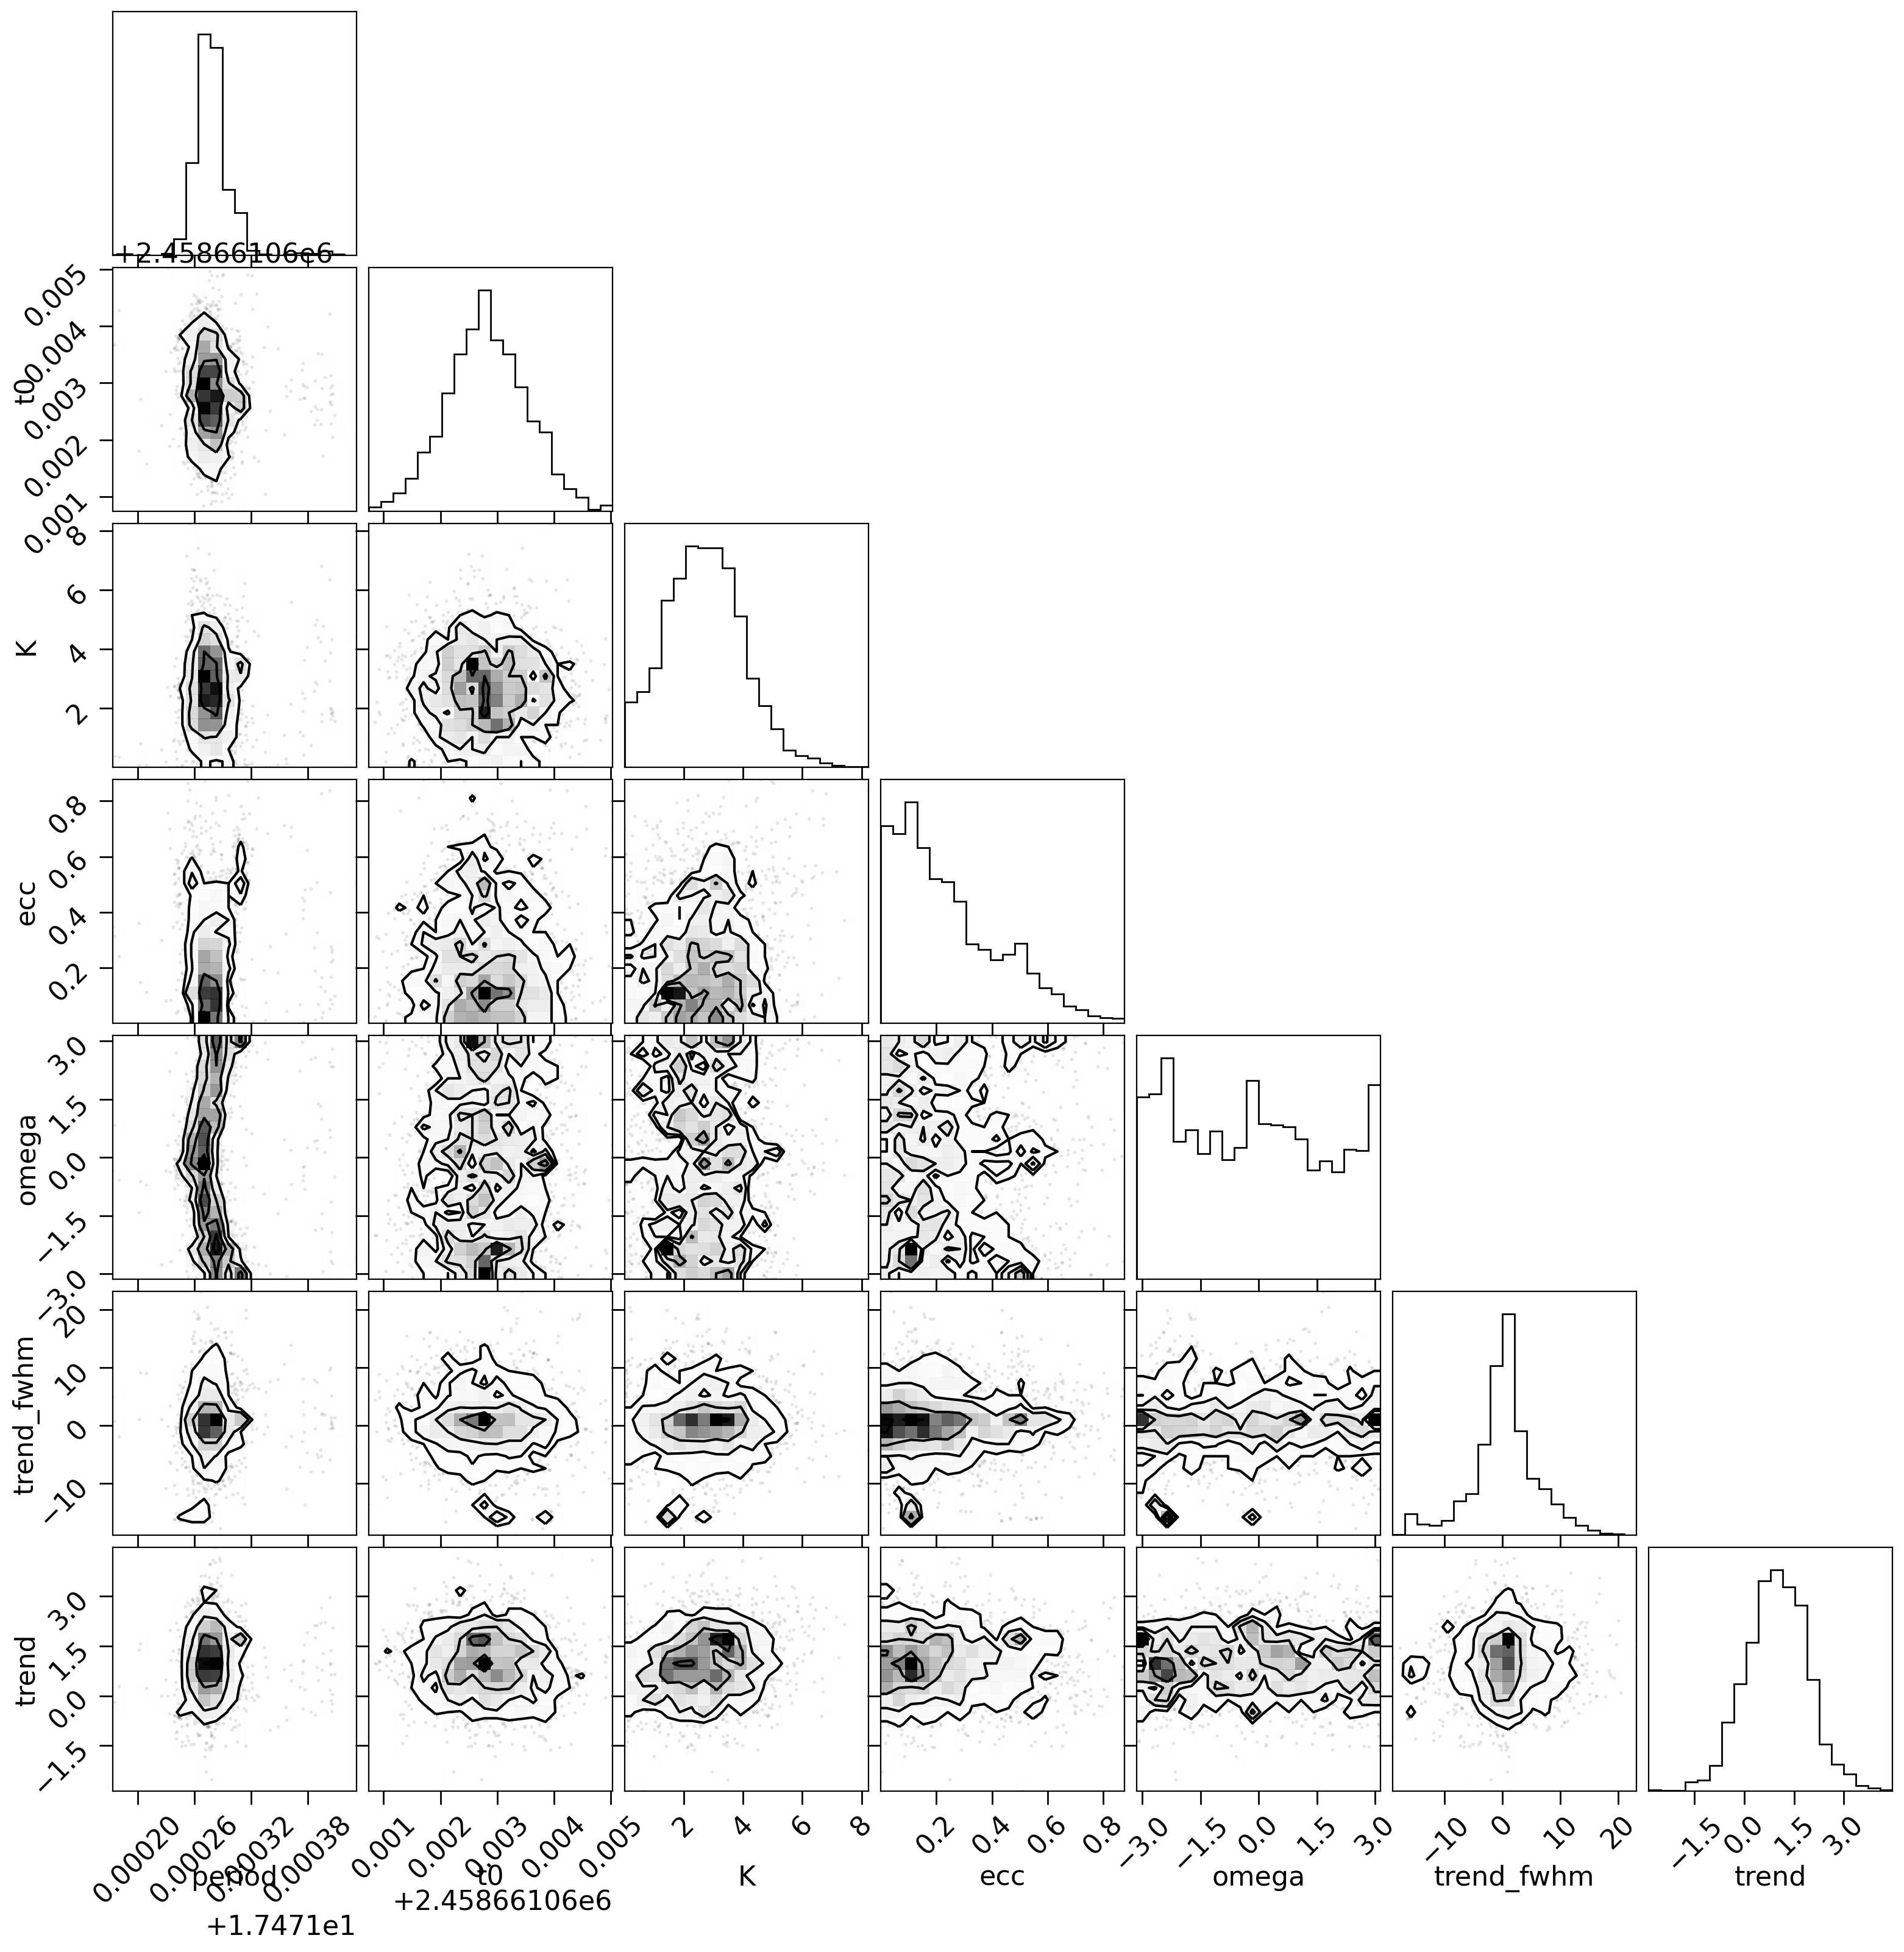

In [17]:
varnames = ["period", "t0", "K", "ecc", "omega", "trend_fwhm", "trend"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)
fig = corner.corner(samples);

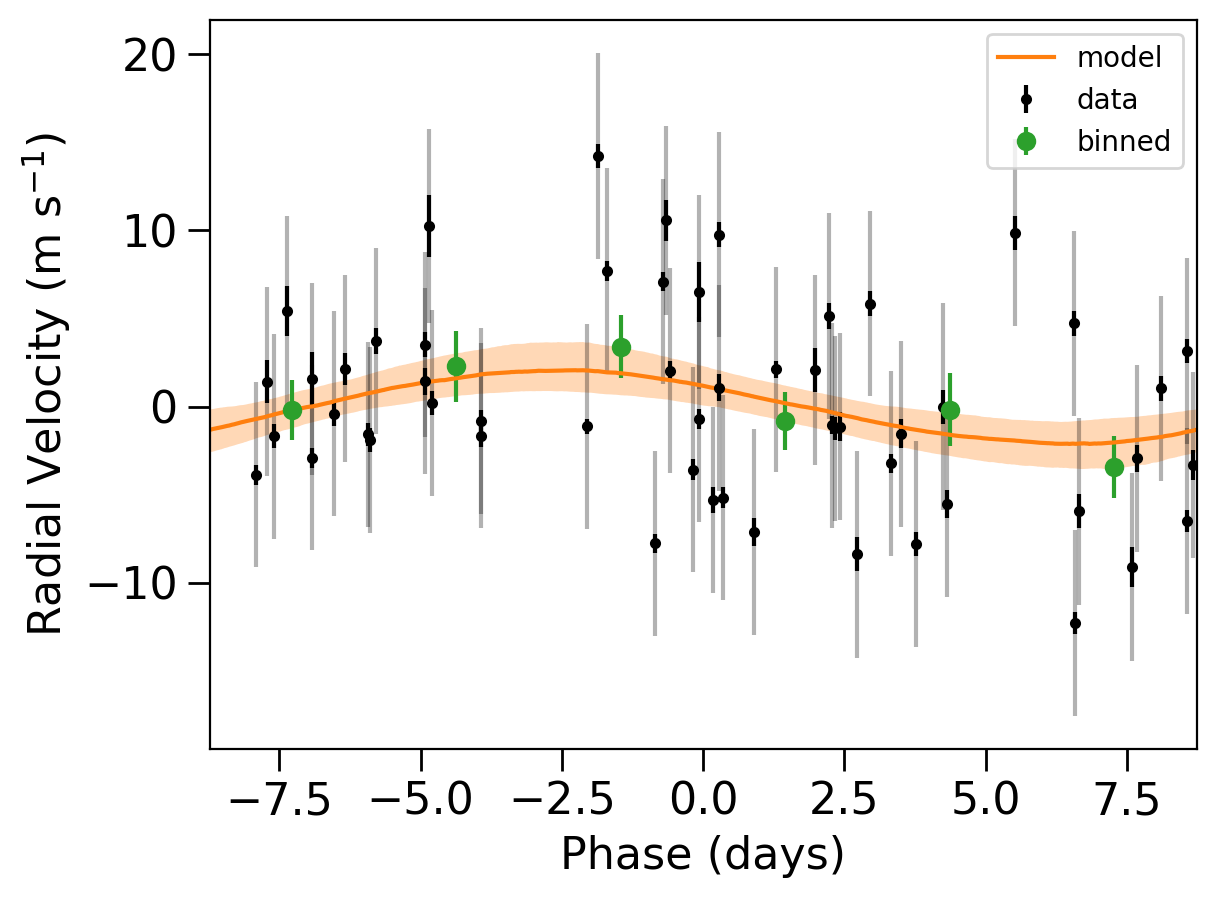

In [18]:
# Get the posterior median orbital parameters
if True:
    p = np.median(trace["period"])
    t0 = np.median(trace["t0"])
    bkg_h1 = np.median(trace["bkg_h1"], axis=0)
    bkg_h2 = np.median(trace["bkg_h2"], axis=0)
    rverr_h1_corrected = np.sqrt(rverr_h1**2+np.exp(2*np.median(trace["logs_h1"])))
    rverr_h2_corrected = np.sqrt(rverr_h2**2+np.exp(2*np.median(trace["logs_h2"])))

# or get the MAP parameters instead
if False:
    p = map_soln["period"]
    t0 = map_soln["t0"]
    bkg_h1 = map_soln["bkg_h1"]
    bkg_h2 = map_soln["bkg_h2"]
    rverr_h1_corrected = np.sqrt(rverr_h1**2+np.exp(2*map_soln["logs_h1"]))
    rverr_h2_corrected = np.sqrt(rverr_h2**2+np.exp(2*map_soln["logs_h2"]))

# Plot the folded data
t_h1_fold = (t_h1 - t0 + 0.5*p) % p - 0.5*p
t_h2_fold = (t_h2 - t0 + 0.5*p) % p - 0.5*p
plt.errorbar(t_h1_fold, rv_h1 - bkg_h1, yerr=rverr_h1_corrected, fmt=",k", alpha=0.3)
plt.errorbar(t_h2_fold, rv_h2 - bkg_h2, yerr=rverr_h2_corrected, fmt=",k", alpha=0.3)
plt.errorbar(t_h1_fold, rv_h1 - bkg_h1, yerr=rverr_h1, fmt=".k", label="data")
plt.errorbar(t_h2_fold, rv_h2 - bkg_h2, yerr=rverr_h2, fmt=".k")


bins = np.linspace(-0.5 * p, 0.5*p, 7)
t_all_fold = np.concatenate([t_h1_fold, t_h2_fold])
weights_all = np.concatenate([(rv_h1 - bkg_h1) / rverr_h1_corrected**2, 
                         (rv_h2 - bkg_h2) / rverr_h2_corrected**2])
weights2_all = np.concatenate([1 / rverr_h1_corrected**2, 1 / rverr_h2_corrected**2])
num, _ = np.histogram(t_all_fold, bins, weights=weights_all)
denom, _ = np.histogram(t_all_fold, bins, weights=weights2_all)
plt.errorbar(0.5*(bins[1:]+bins[:-1]), num / denom, yerr=1 / np.sqrt(denom),
             fmt="o", color="C2", label="binned")

# Compute the posterior prediction for the folded RV model for this
# planet
t_fold = (t_dense - t0 + 0.5*p) % p - 0.5*p
inds = np.argsort(t_fold)
pred = np.percentile(trace["vrad_pred"][:, inds], [16, 50, 84], axis=0)
plt.plot(t_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(t_fold[inds], pred[0], pred[2], color="C1", alpha=0.3)
art.set_edgecolor("none")


plt.legend(fontsize=10)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("Phase (days)")
plt.ylabel("Radial Velocity (m s$^{-1}$)")
plt.tight_layout()
plt.savefig(plot_dir+'rvphased_fwhm_o{0}.pdf'.format(rv_trend_order));